#### 1) 표준화/정규화 없이 xgboost
결과: 표준화/정규화 없이 xgboost-XGBRegressor 사용했더니 

예측값과 정답 값을 RMSLE로 평가했을 때 다음과 같은 오류가 발생했다.

Mean Squared Logarithmic Error cannot be used when targets contain negative values.

XGBRegressor 자전거 대여량을 음수값으로도 예측해서 발생한 오류. 카운트 해보니 15개의 값이 음수였다.! \
XGBRegressor의 objective_파라미터를 기존 값이었던 `reg:linear` 대신 `count:poisson`으로 바꾸고 다시 해보기\error-> `reg:squaredlogerror`


In [1]:
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_squared_log_error
import xgboost
import numpy as np
import pandas as pd

In [5]:
train_data = pd.read_csv('data/preprocessed_train.csv', index_col='datetime')

In [6]:
train_data

,season,weather,temp,atemp,humidity,windspeed,day_type,hour,count
datetime,,,,,,,,,
2011-01-01 00:00:00,1,1,9.84,14.395,81,0.0000,2,0,16
2011-01-01 01:00:00,1,1,9.02,13.635,80,0.0000,2,1,40
2011-01-01 02:00:00,1,1,9.02,13.635,80,0.0000,2,2,32
2011-01-01 03:00:00,1,1,9.84,14.395,75,0.0000,2,3,13
2011-01-01 04:00:00,1,1,9.84,14.395,75,0.0000,2,4,1
...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,4,1,15.58,19.695,50,26.0027,1,19,336
2012-12-19 20:00:00,4,1,14.76,17.425,57,15.0013,1,20,241
2012-12-19 21:00:00,4,1,13.94,15.910,61,15.0013,1,21,168


In [10]:
train_x = train_data.iloc[:,:-1]
train_y = train_data.iloc[:,-1]
display(train_x)
display(train_y)

,season,weather,temp,atemp,humidity,windspeed,day_type,hour
datetime,,,,,,,,
2011-01-01 00:00:00,1,1,9.84,14.395,81,0.0000,2,0
2011-01-01 01:00:00,1,1,9.02,13.635,80,0.0000,2,1
2011-01-01 02:00:00,1,1,9.02,13.635,80,0.0000,2,2
2011-01-01 03:00:00,1,1,9.84,14.395,75,0.0000,2,3
2011-01-01 04:00:00,1,1,9.84,14.395,75,0.0000,2,4
...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,4,1,15.58,19.695,50,26.0027,1,19
2012-12-19 20:00:00,4,1,14.76,17.425,57,15.0013,1,20
2012-12-19 21:00:00,4,1,13.94,15.910,61,15.0013,1,21


datetime
2011-01-01 00:00:00     16
2011-01-01 01:00:00     40
2011-01-01 02:00:00     32
2011-01-01 03:00:00     13
2011-01-01 04:00:00      1
                      ... 
2012-12-19 19:00:00    336
2012-12-19 20:00:00    241
2012-12-19 21:00:00    168
2012-12-19 22:00:00    129
2012-12-19 23:00:00     88
Name: count, Length: 10886, dtype: int64

In [11]:
x_train, x_valid, y_train, y_valid = train_test_split(train_x, train_y, test_size=0.2, random_state=1)
print(x_train.shape, x_valid.shape, y_train.shape, y_valid.shape)

(8708, 8) (2178, 8) (8708,) (2178,)


In [12]:
def RMSLE(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [19]:
model = xgboost.XGBRegressor(objective='reg:squaredlogerror')
model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, objective='reg:squaredlogerror', ...)

In [28]:
preds = model.predict(x_valid)
preds = np.array(list(map(lambda x:-x if x<0 else x, preds)))
print(RMSLE(y_valid, preds))

0.778023529908258


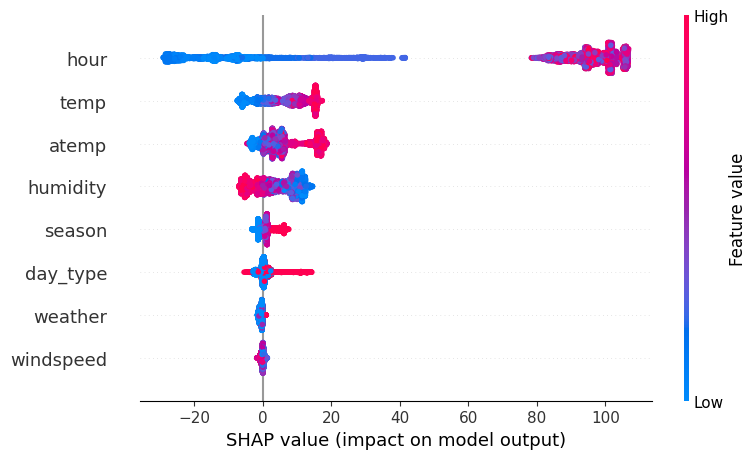

In [29]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values, x_train)

In [30]:
def get_daytype(row):
    if row['holiday'] == 0 and row['workingday'] == 1: #workingday
        return 1
    elif row['holiday'] == 0 and row['workingday'] == 0: #weekend
        return 2
    elif row['holiday'] == 1 and row['workingday'] == 0: #holiday
        return 3

In [34]:
train_data

,season,weather,temp,atemp,humidity,windspeed,day_type,hour,count
datetime,,,,,,,,,
2011-01-01 00:00:00,1,1,9.84,14.395,81,0.0000,2,0,16
2011-01-01 01:00:00,1,1,9.02,13.635,80,0.0000,2,1,40
2011-01-01 02:00:00,1,1,9.02,13.635,80,0.0000,2,2,32
2011-01-01 03:00:00,1,1,9.84,14.395,75,0.0000,2,3,13
2011-01-01 04:00:00,1,1,9.84,14.395,75,0.0000,2,4,1
...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,4,1,15.58,19.695,50,26.0027,1,19,336
2012-12-19 20:00:00,4,1,14.76,17.425,57,15.0013,1,20,241
2012-12-19 21:00:00,4,1,13.94,15.910,61,15.0013,1,21,168


In [38]:
test_data = pd.read_csv('data/test.csv', index_col='datetime')
test_data.index = pd.to_datetime(test_data.index)
test_data

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
datetime,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014
...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014
2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014
2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014


In [39]:
test_data['day_type'] = test_data.apply(get_daytype, axis=1)
test_data = test_data.drop(columns=['holiday', 'workingday'])
test_data['hour'] = test_data.index.hour
test_data

,season,weather,temp,atemp,humidity,windspeed,day_type,hour
datetime,,,,,,,,
2011-01-20 00:00:00,1,1,10.66,11.365,56,26.0027,1,0
2011-01-20 01:00:00,1,1,10.66,13.635,56,0.0000,1,1
2011-01-20 02:00:00,1,1,10.66,13.635,56,0.0000,1,2
2011-01-20 03:00:00,1,1,10.66,12.880,56,11.0014,1,3
2011-01-20 04:00:00,1,1,10.66,12.880,56,11.0014,1,4
...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,1,2,10.66,12.880,60,11.0014,1,19
2012-12-31 20:00:00,1,2,10.66,12.880,60,11.0014,1,20
2012-12-31 21:00:00,1,1,10.66,12.880,60,11.0014,1,21


In [40]:
pred = model.predict(test_data)

In [43]:
pred = np.array(list(map(lambda x:-x if x<0 else x, pred)))

In [51]:
pred

array([ 12.500494 ,   6.399134 ,   2.8644629, ..., 124.72534  ,
       126.21104  , 123.931656 ], dtype=float32)

In [57]:
pred = np.array(list(map(int, pred)))

In [58]:
pred

array([ 12,   6,   2, ..., 124, 126, 123])

In [59]:
submission = pd.read_csv('data/sampleSubmission.csv')
submission['count'] = pred
submission

,datetime,count
0,2011-01-20 00:00:00,12
1,2011-01-20 01:00:00,6
2,2011-01-20 02:00:00,2
3,2011-01-20 03:00:00,2
4,2011-01-20 04:00:00,2
...,...,...
6488,2012-12-31 19:00:00,125
6489,2012-12-31 20:00:00,125
6490,2012-12-31 21:00:00,124
6491,2012-12-31 22:00:00,126


In [61]:
submission.to_csv('data/sampleSubmission-v1.csv', index=False)